# Load dependencies

In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!cp -r "drive/My Drive/deepSIBA_pytorch/NGF" /content
!cp -r "drive/My Drive/deepSIBA_pytorch/NGF_layers" /content
!cp -r "drive/My Drive/deepSIBA_pytorch/utility" /content
!cp -r "drive/My Drive/deepSIBA_pytorch/utils" /content
!cp -r "drive/My Drive/deepsiba_tf2/data" /content
!cp "drive/My Drive/deepSIBA_pytorch/deepSIBA_model.py" /content

In [ ]:
#!rm -r NGF_layers
#!rm -r utility
#!rm -r utils
#!rm -r data
#!rm deepSIBA_model.py

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from numpy import inf, ndarray
import pandas as pd
import os
import random
import sklearn
import re
#from NGF.utils import filter_func_args, mol_shapes_to_dims
#import NGF.utils
import NGF_layers.features
import NGF_layers.graph_layers
from NGF_layers.features import one_of_k_encoding, one_of_k_encoding_unk, atom_features, bond_features, num_atom_features, num_bond_features, padaxis, tensorise_smiles #, concat_mol_tensors
from NGF_layers.graph_layers import NeuralGraphHidden
from math import ceil
from sklearn.metrics import mean_squared_error
from utility.gaussian import GaussianLayer, custom_loss, ConGaussianLayer
from utility.evaluator import r_square, get_cindex, pearson_r,custom_mse, mse_sliced, model_evaluate
from utility.Generator import train_generator,preds_generator
from deepSIBA_model import enc_graph, siamese_model
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from torch import norm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
sns.set()

# Load train and model parameters

In [2]:
#model_params
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_in" : int(60), "conv1d_out" : int(32), "kernel_size" : int(1), "dropout_encoder" : 0.25,
    "conv1d_dist_in" : [32,16], "conv1d_dist_out" : [16,16], "conv1d_dist_kernels" : [1,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.0005 ,"ConGauss": True
}

In [3]:
train_params = {
    "cell_line" : "a375", "split" : "train_test_split", "number_folds" : [0],
    "output_dir" : "results",
    "batch_size" : int(128), "epochs" : int(15), 
    "N_ensemble" : int(1), "nmodel_start" : int(0), "prec_threshold" : 0.2,
    "Pre_training" : False,
    "Pre_trained_cell_dir" : '',
    "pattern_to_load" : 'siam_no_augment_',
    "model_id_to_load" : "20",
    "test_value_norm" : True,
    "predict_batch_size":int(1024)
}

# Load data

In [4]:
get_all = []
if train_params["split"] == "train_test_split":
  outer_loop = train_params["number_folds"]
elif train_params["split"] == "5_fold_cv_split":
  outer_loop = train_params["number_folds"]
elif train_params["split"] == "alldata":
  outer_loop = train_params["number_folds"]
#Load unique smiles and tensorize them
smiles = pd.read_csv("data/" + train_params["cell_line"] + "/" + train_params["cell_line"] + "q1smiles.csv", index_col=0)
X_atoms, X_bonds, X_edges = tensorise_smiles(smiles.x, model_params["max_degree"], model_params["max_atoms"])
smiles=list(smiles['x'])

In [5]:
df = pd.read_csv("data/" + train_params["cell_line"] + "/" + "train_test_split/" + "train.csv",index_col=0).reset_index(drop=True)
df_cold = pd.read_csv("data/" + train_params["cell_line"] + "/" + "train_test_split/" + "test.csv",index_col=0).reset_index(drop=True)
smiles_cold = list(set(list(df_cold['rdkit.x'])+list(df_cold['rdkit.y'])))
X_atoms_cold, X_bonds_cold, X_edges_cold = tensorise_smiles(smiles_cold,  model_params["max_degree"], model_params["max_atoms"])
#X_atoms_cold=X_atoms_cold.astype('float64')
#X_bonds_cold=X_bonds_cold.astype('float64')
#X_edges_cold=X_edges_cold.astype('int64')
if train_params["test_value_norm"]:
  Y_cold = df_cold.value
else:
  Y_cold = df_cold.value
  Y_cold = Y_cold/2

In [6]:
i=0
Path(train_params["output_dir"] + "/" + "fold_%s/models"%i).mkdir(parents=True, exist_ok=True)
cold_preds_mus = []
cold_preds_sigmas = []
n = train_params["nmodel_start"]

# Define,Compile,Train model

In [7]:
deepsiba = siamese_model(model_params)

In [8]:
def get_default_device():
  if torch.cuda.is_available():
    print('cuda mode')
    return torch.device('cuda')
  else:
    print('cpu mode')
  return torch.device('cpu')
device=get_default_device()

cuda mode


In [9]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device)

In [10]:
class train_generator(Dataset):

  def __init__(self, data,smiles,X_atoms, X_bonds, X_edges):
    self.df=data
    self.smiles=smiles
    self.X_atoms=X_atoms
    self.X_bonds=X_bonds
    self.X_edges=X_edges
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    smi1=self.df['rdkit.x'][index]
    smi2=self.df['rdkit.y'][index]
    d=self.df.value[index]/2
    ind1=self.smiles.index(smi1)
    ind2=self.smiles.index(smi2)
    atom_1=torch.tensor(self.X_atoms[ind1])
    atom_1=torch.tensor(self.X_atoms[ind1])
    bond_1=torch.tensor(self.X_bonds[ind1])
    edge_1=torch.tensor(self.X_edges[ind1])
    atom_2=torch.tensor(self.X_atoms[ind2])
    bond_2=torch.tensor(self.X_bonds[ind2])
    edge_2=torch.tensor(self.X_edges[ind2])
    return atom_1,bond_1,edge_1,atom_2,bond_2,edge_2,torch.tensor(d)

In [11]:
bs = train_params["batch_size"]
NUM_EPOCHS = train_params["epochs"]
df = df.sample(frac=1).reset_index(drop=True)
NUM_TRAIN = len(df)
NUM_STEPS=ceil(NUM_TRAIN/bs)
trainGen=train_generator(df,smiles,X_atoms, X_bonds, X_edges)

In [12]:
#num_workers=12 mporei na mpei ki ayto sto DataLoader
train_loader = DataLoader(trainGen,
                          batch_size=bs,
                          shuffle=True)

In [13]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [14]:
train_loader=DeviceDataLoader(train_loader,device)

In [15]:
deepsiba=to_device(deepsiba,device)

In [16]:
#from pytorch_lightning.core.lightning import LightningModule
#from pytorch_lightning import Trainer

In [17]:
#trainer = Trainer(auto_lr_find=True)

# Run learning rate finder
#lr_finder = trainer.tuner.lr_find(deepsiba,train_dataloader=train_loader, min_lr=1e-08, max_lr=1, num_training=100)


In [18]:
# Plot with
##fig = lr_finder.plot(suggest=True)
#fig.show()

In [19]:
# Pick point based on plot, or get suggestion
#new_lr = lr_finder.suggestion()
#print(new_lr)

In [20]:
adam = torch.optim.Adam(deepsiba.parameters(),lr=model_params["lr"],weight_decay=model_params["l2reg"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam, 'min',factor=0.5,patience=3, min_lr=0.00001, eps=1e-5,verbose=True)

In [21]:
def train(epoch):
  deepsiba.train()
  for atom1,bond1,edge1,atom2,bond2,edge2,y_true in train_data_iterator:
    #print(len(tb))
    #tb = tb.to(dev)
    adam.zero_grad()
    
    y_pred = deepsiba(atom1,bond1,edge1,atom2,bond2,edge2)
    #reg=norm(deepsiba.encoder.g1.inner_3D_layers[0].weight)**2 + norm(deepsiba.encoder.g2.inner_3D_layers[0].weight)**2
    #for j in range(1,model_params["max_degree"]):
    #    reg=reg+norm(deepsiba.encoder.g1.inner_3D_layers[j].weight)**2 + norm(deepsiba.encoder.g2.inner_3D_layers[j].weight)**2
    #reg=reg + norm(deepsiba.dense1.weight)**2+norm(deepsiba.dense2.weight)**2+norm(deepsiba.dense3.weight)**2
    loss = custom_loss(y_true,y_pred)
    r=r_square(y_true,y_pred)
    pear=pearson_r(y_true,y_pred)
    mse=custom_mse(y_true,y_pred)
    mse_similars=mse_sliced(y_true,y_pred,0.2)
    cindex=get_cindex(y_true,y_pred)
    
    train_data_iterator.set_postfix(
        Epoch=epoch + 1,
        r2='%.4f' % float(r),
        pearson='%.4f' % float(pear),
        Cindex='%.4f' % float(cindex),
        Loss='%.4f' % float(loss.item()))
    loss.backward()
    #torch.nn.utils.clip_grad_value_(deepsiba.parameters(), 0.5)
    #torch.nn.utils.clip_grad_norm_(deepsiba.parameters(), 1.0)
    adam.step()

  scheduler.step(loss)

In [22]:
for epoch in range(NUM_EPOCHS):
  train_data_iterator = tqdm(train_loader,
                             leave=True,
                             unit='batch',
                             postfix={
                                 'Epoch': epoch + 1,
                                 'r2':'%.4f' % float("NaN"),
                                 'pearson':'%.4f' % float("NaN"),
                                 'Cindex':'%.4f' % float("NaN"),
                                 'Loss': '%.4f' % float("NaN")})
  train(epoch)

In [24]:
torch.save(deepsiba.state_dict(),'mymodel_3.pth')

In [25]:
class preds_generator(Dataset):

  def __init__(self, df_cold,smiles_cold,X_atoms_cold, X_bonds_cold, X_edges_cold):
    self.df=df_cold
    self.smiles=smiles_cold
    self.X_atoms=X_atoms_cold
    self.X_bonds=X_bonds_cold
    self.X_edges=X_edges_cold
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    smi1=self.df['rdkit.x'][index]
    smi2=self.df['rdkit.y'][index]
    ind1=self.smiles.index(smi1)
    ind2=self.smiles.index(smi2)
    d=self.df.value[index]
    atom_1=torch.tensor(self.X_atoms[ind1])
    bond_1=torch.tensor(self.X_bonds[ind1])
    edge_1=torch.tensor(self.X_edges[ind1])
    atom_2=torch.tensor(self.X_atoms[ind2])
    bond_2=torch.tensor(self.X_bonds[ind2])
    edge_2=torch.tensor(self.X_edges[ind2])

    return atom_1,bond_1,edge_1,atom_2,bond_2,edge_2,torch.tensor(d)

In [26]:
PredGen=preds_generator(df_cold,smiles_cold,X_atoms_cold, X_bonds_cold, X_edges_cold)

In [27]:
eval_loader = DataLoader(PredGen,
                          batch_size=train_params["predict_batch_size"],shuffle=False)

In [28]:
eval_loader=DeviceDataLoader(eval_loader,device)

In [29]:
def predict():
  with torch.no_grad():
    deepsiba.eval()
    y_pred1=[]
    y_pred2=[]
    for atom1,bond1,edge1,atom2,bond2,edge2,y_true in eval_data_iterator:
      
      y_pred = deepsiba(atom1,bond1,edge1,atom2,bond2,edge2)
      y_pred = y_pred.cpu().numpy()
      #y_pred=y_pred.to('cpu')
      y_pred1=y_pred1+list(y_pred[:,0])
      y_pred2=y_pred2+list(y_pred[:,1])

  #y_pred1=torch.cat(y_pred1,dim=0)
  #y_pred2=torch.cat(y_pred2,dim=0)

  return y_pred1,y_pred2

In [30]:
eval_data_iterator = tqdm(eval_loader,
                          leave=True,
                          unit='batch')
y_pred1,y_pred2=predict()
##kanta numpy arrays meta

In [31]:
y_pred1=np.array(y_pred1)
y_pred2=np.array(y_pred2)

In [32]:
if (len(y_pred1[np.where(y_pred1 <= train_params["prec_threshold"])])>0):
  get = model_evaluate(y_pred1,Y_cold,train_params["prec_threshold"],df_cold)
  #get.to_csv(train_params["output_dir"] + "/" + "fold_%s/performance/"%i + "model_%s.csv"%n)

In [33]:
get

,cor,mse_all,mse_similars,precision,accuracy,FPR,positives
0,0.465824,0.0102,0.012213,0.366596,0.794884,0.102258,6113


(array([ 5128., 11677., 12842., 10443.,  4305.,   720.,   237.,   155.,
           40.,    37.]),
 array([0.13540564, 0.19275038, 0.25009513, 0.30743986, 0.3647846 ,
        0.42212933, 0.47947407, 0.5368188 , 0.59416354, 0.6515083 ,
        0.708853  ], dtype=float32),
 <BarContainer object of 10 artists>)

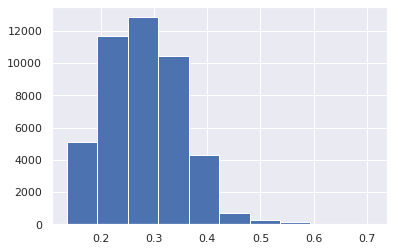

In [34]:
plt.hist(y_pred1)

(array([  747.,  6398., 15203., 12809.,  6104.,  2669.,  1144.,   399.,
           93.,    18.]),
 array([0.02559433, 0.11045007, 0.19530581, 0.28016155, 0.36501729,
        0.44987303, 0.53472877, 0.61958451, 0.70444025, 0.78929599,
        0.87415173]),
 <BarContainer object of 10 artists>)

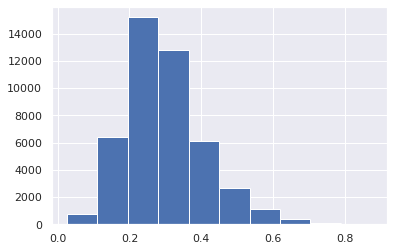

In [35]:
plt.hist(Y_cold)

In [ ]:
deepsiba.load_state_dict(torch.load('mymodel.pth'))

<All keys matched successfully>

In [21]:
import torch
import torch.nn as nn
from functools import reduce

In [27]:
a=reduce(torch.add, [torch.randn(5,3,3),torch.randn(5,3,3),torch.randn(5,3,3)])
print(a.shape)
print(a)

torch.Size([5, 3, 3])
tensor([[[-0.3007,  3.2333, -0.8251],
         [ 0.4298, -3.2982, -1.8805],
         [ 2.0885,  2.9607, -1.0951]],

        [[ 1.1855,  0.5860, -1.3978],
         [ 1.5272,  0.1069,  0.4718],
         [ 0.9711,  4.0937, -0.2819]],

        [[ 1.9455, -2.2948,  0.4802],
         [-0.6749,  0.0083,  0.7549],
         [-0.2512, -2.6906,  2.4765]],

        [[ 0.6817, -0.1131, -2.7119],
         [-0.4547,  0.0230, -3.0362],
         [ 1.7237,  1.0946,  2.1156]],

        [[-0.8097,  2.7845,  0.8568],
         [ 1.4246, -2.6880, -1.1546],
         [ 1.4122, -1.9375,  0.5850]]])


In [46]:
mask=torch.tensor([[1,0,0],
                   [0,1,0],
                   [0,0,1],
                   [0,1,1],
                   [1,1,1]])

In [69]:
atom_degrees = torch.sum((edges.eq(1)), dim=-1, keepdim=True) - 1

In [70]:
atom_degrees[0]

tensor([[1],
        [4],
        [1],
        [1],
        [3],
        [2],
        [3],
        [3],
        [2],
        [2],
        [2],
        [3],
        [2],
        [4],
        [1],
        [1],
        [3],
        [3],
        [1],
        [2],
        [2],
        [2],
        [3],
        [1],
        [3],
        [1],
        [3],
        [3],
        [2],
        [2],
        [2],
        [3],
        [1],
        [2],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')

In [71]:
atom_masks_this_degree = atom_degrees.eq(int(4))

In [72]:
new_masked_features = atoms * atom_masks_this_degree

In [78]:
atom_masks_this_degree.shape

torch.Size([5, 60, 1])

In [77]:
new_masked_features.shape

torch.Size([5, 60, 62])

In [45]:
atoms=to_device(torch.tensor(X_atoms[0:5]),device)
bonds=to_device(torch.tensor(X_bonds[0:5]),device)
edges=to_device(torch.tensor(X_edges[0:5]),device)

In [20]:
# Import dimensions
atoms_shape = list(atoms.size())
batch_n = atoms_shape[0]
lookup_size = atoms_shape[1]
num_atom_features = atoms_shape[2]

edges_shape = list(edges.size())
max_atoms = edges_shape[1]
max_degree = edges_shape[2]

In [15]:
max_degree

5

In [20]:
bs=5
max_degree=5
atom_feats=62
max_atoms=60

In [27]:
edges.shape

torch.Size([5, 60, 5])

In [21]:
atom_degrees = torch.sum((~edges.eq(-1)).type(torch.cuda.FloatTensor), dim=-1, keepdim=True)

In [22]:
new_edges=torch.cat([torch.reshape(torch.linspace(0,max_atoms-1,60).type(torch.cuda.LongTensor).repeat(bs),(bs,max_atoms,1)),edges],dim=-1)

In [23]:
new_edges.shape

torch.Size([5, 60, 6])

In [30]:
atoms.shape

torch.Size([5, 60, 62])

In [24]:
x=torch.reshape(atoms,(bs*max_atoms,atom_feats))[torch.reshape(new_edges,(bs*max_atoms,max_degree+1))]

In [25]:
x=x.view(bs,max_atoms,max_degree+1,atom_feats)

In [26]:
x.shape

torch.Size([5, 60, 6, 62])

In [124]:
atom_degrees[:,0:max_atoms,0].eq(degree).shape

torch.Size([5, 60])

In [126]:
for degree in range(max_degree):
    x[atom_degrees[:,0:max_atoms,0].eq(degree),:,(max_degree-degree+1):max_degree+1]=0

In [132]:
x

torch.Size([5, 60, 6, 62])

In [ ]:
import pytorch-geometric

In [59]:
edge_tensor = np.zeros((512, 60 or 1, 60 or 1), dtype=int)

In [60]:
di=np.diag_indices(60)
for i in range(512):
    x=edge_tensor[i]
    x[di]=1
    edge_tensor[i]=x

In [61]:
edge_tensor

array([[[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [42]:
atoms=torch.tensor(X_atoms).to(device)
bonds=torch.tensor(X_bonds).to(device)
edges=torch.tensor(X_edges).to(device)

NameError: name 'device' is not defined